In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Loading datasets
train = pd.read_csv("titanic_train.csv")
test = pd.read_csv("titanic_test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Inspecting the results of head() and tail() methods, some aspects need to be clarified:
#     both datasets are provided with NaN values, noticeably in the "Cabin" and "Age" columns
#         the "Cabin" column may be dropped in the future
#         the NaN values in the "Age" column may be imputed with mean age values based upon some feature
#         further, any remaining rows containing NaN may be dropped
#     the columns "PassengerId", "Name", "Ticket" may have not any predictive meaning and may be dropped
#     categorical columns "Pclass", "Sex" and "Embarked" may be transformed into dummy variables
#     the test dataset already lacks the column "Survived", ie the target column

In [5]:
train.drop(["PassengerId", "Name", "Ticket"], axis=1, inplace=True)
test.drop(["PassengerId", "Name", "Ticket"], axis=1, inplace=True)

<Axes: >

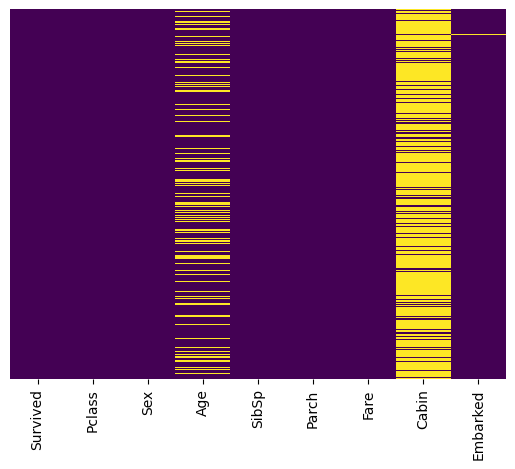

In [6]:
# In order to visualize NaN entities:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap="viridis")

<Axes: >

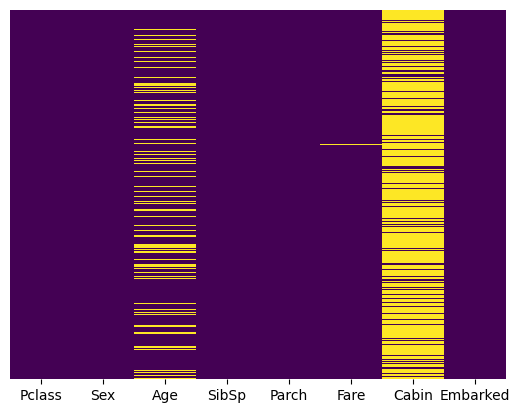

In [7]:
sns.heatmap(test.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [8]:
print("---------- Missing values ----------")
print(f"(train set): % of missing values in the 'Cabin' column: {(train['Cabin'].isnull().value_counts()[0])/(len(train['Cabin']))}")
print(f"(test set): % of missing values in the 'Cabin' column: {(test['Cabin'].isnull().value_counts()[0])/(len(test['Cabin']))}")

---------- Missing values ----------
(train set): % of missing values in the 'Cabin' column: 0.7710437710437711
(test set): % of missing values in the 'Cabin' column: 0.7822966507177034


In [9]:
# Dropping the "Cabin" column
train.drop(["Cabin"], axis=1, inplace=True)
test.drop(["Cabin"], axis=1, inplace=True)

<Axes: xlabel='Survived', ylabel='count'>

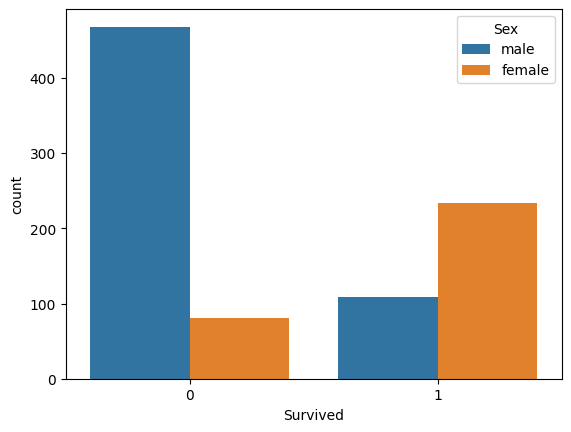

In [10]:
# Looking for a relationship between categories Survived and Sex
sns.countplot(data=train, x="Survived", hue="Sex")

<Axes: xlabel='Survived', ylabel='count'>

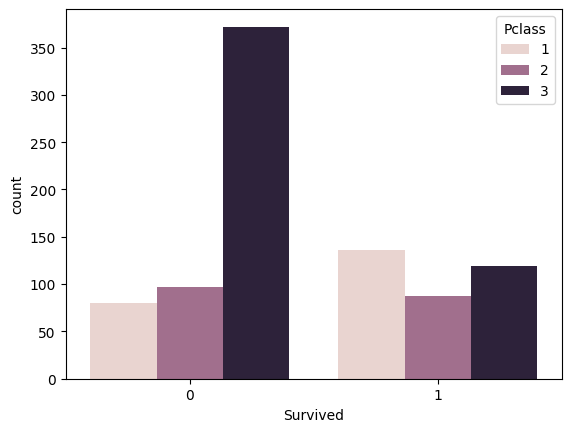

In [11]:
# Looking for a relationship between categories Survived and Pclass
sns.countplot(data=train, x="Survived", hue="Pclass")

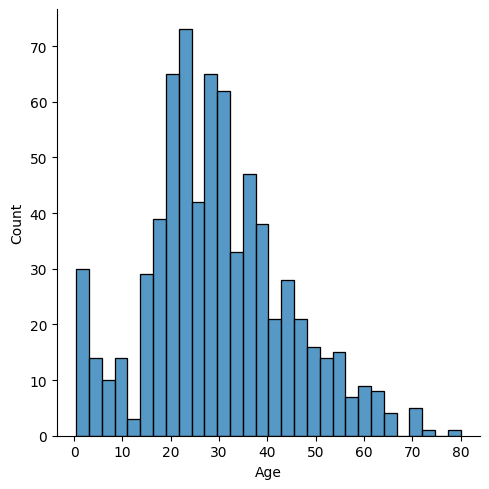

In [12]:
# Inspecting the distribution of ages
sns.displot(train["Age"].dropna(), bins=30)

<Axes: xlabel='Sex', ylabel='Age'>

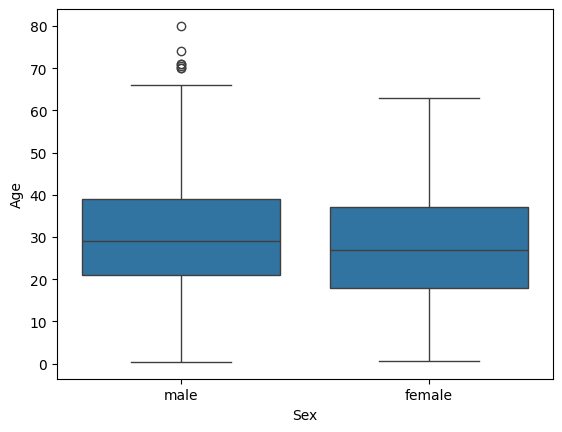

In [13]:
sns.boxplot(data=train, x="Sex", y="Age")

In [14]:
# Looking for mean values of ages basing upon Pclass

mean_ages_train = train.groupby("Pclass").mean(numeric_only=True)["Age"]
mean_ages_test = test.groupby("Pclass").mean(numeric_only=True)["Age"]

In [15]:
# Defining functions to apply to datasets
def impute_age_train(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return mean_ages_train.iloc[int(Pclass-1)]
    else:
        return Age

def impute_age_test(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return mean_ages_test.iloc[int(Pclass-1)]
    else:
        return Age

In [16]:
# Substituting NAN ages

train["Age"] = train[["Age", "Pclass"]].apply(impute_age_train, axis=1)
test["Age"] = test[["Age", "Pclass"]].apply(impute_age_test, axis=1)

In [17]:
# Removing sparse rows where NAN are present
train.dropna(inplace=True)
test.dropna(inplace=True)

In [18]:
# Replacing Sex and Embarked columns with dummy variables

sex_train = pd.get_dummies(train["Sex"], drop_first=True)
embarked_train = pd.get_dummies(train["Embarked"], drop_first=True)
sex_test = pd.get_dummies(test["Sex"], drop_first=True)
embarked_test = pd.get_dummies(test["Embarked"], drop_first=True)

train = pd.concat([train, sex_train, embarked_train], axis=1)
test = pd.concat([test, sex_test, embarked_test], axis=1)

train.drop(["Sex", "Embarked"], inplace=True, axis=1)
test.drop(["Sex", "Embarked"], inplace=True, axis=1)

# Converting bools to integers

train["male"] = train["male"].astype(int)
train["Q"] = train["Q"].astype(int)
train["S"] = train["S"].astype(int)
test["male"] = test["male"].astype(int)
test["Q"] = test["Q"].astype(int)
test["S"] = test["S"].astype(int)

In [19]:
# Replacing Pclass column with dummy variables as well

class_train = pd.get_dummies(train["Pclass"], drop_first=True)
class_test = pd.get_dummies(test["Pclass"], drop_first=True)

train = pd.concat([train, class_train], axis=1)
test = pd.concat([test, class_test], axis=1)

train.drop("Pclass", inplace=True, axis=1)
test.drop("Pclass", inplace=True, axis=1)

# Converting bools to integers

train[2] = train[2].astype(int)
train[3] = train[3].astype(int)
test[2] = test[2].astype(int)
test[3] = test[3].astype(int)

In [28]:
# Preparing data for linear logistic regression
# Correcting column names
train = train.rename(columns={2: '2', 3: '3'})
test = test.rename(columns={2: "2", 3: "3"})

In [21]:
X_train = train.drop("Survived", axis=1)
y_train = train["Survived"]

In [24]:
from sklearn.linear_model import LogisticRegression
logm = LogisticRegression(max_iter=1000)

In [25]:
logm.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [31]:
preds = logm.predict(test)
preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,